In [ ]:
import os
import json
from typing import List

import pandas

benchmark_result_dir = "/home/coder/projects/vllm/outputs/relay_op_a40_benchmark"

all_data = []
# Loop through the items in the directory
for item in os.listdir(benchmark_result_dir):
    subdir_full_path = os.path.join(benchmark_result_dir, item)
    # Check if the item is a subdirectory
    if not (item.startswith('nreqs') and os.path.isdir(subdir_full_path)):
        print(f'skipping {item}')
        continue
    # Parse dir name to configs 
    configs = {}
    pairs = item.split('.')
    for pair in pairs:
        key, value = pair.split('_')
        try:
            value = int(value)
        except ValueError:
            pass
        # Add the key-value pair to the dictionary
        configs[key] = value
    # Read the benchmark result
    with open(os.path.join(subdir_full_path, 'benchmark.json')) as file:
        metrics = json.load(file)
    
    # Read the profile result and analyze
    with open(os.path.join(subdir_full_path, 'profile.json')) as file:
        profile = json.load(file)
    def get_event(fuzzy_event_name:str, events:List[dict]):
        for e in events:
            if fuzzy_event_name in e["name"]:
                return e
        return None
    # TODO: there is a reduce kernel in PagedAttentionV2 
    event2fuzzyid={
        "cache_op": "vllm::reshape_and_cache_kernel",
        "attn_usr": "vllm::paged_attention",
        "attn_sys": "flash_fwd",
        "relay_fusion": "_relay_fuse_kernel"
    }
    durations = {}
    for event_name, fuzzy_id in event2fuzzyid.items():
        event = get_event(fuzzy_id, events=profile["traceEvents"])
        if event is not None:
        # print(item, event_name)
            durations[event_name] = event['dur']
        else:
            assert configs['relay'] == "false"
            durations[event_name] = 0
    durations['others'] = metrics['Lantency (us)'] - sum(durations.values())

    # print(configs, metrics, durations)
    all_data.append({**configs, **metrics, **durations})

df = pandas.DataFrame(all_data)
df.to_csv(os.path.join(benchmark_result_dir, "summary.csv"), index=False)

In [ ]:
from matplotlib import pyplot as plt

nreqs_plot = 32

latency_relay = df[(df['nreqs']==nreqs_plot) & (df['relay'] == 'true')].sort_values('prefixlen')
latency_norelay = df[(df['nreqs']==nreqs_plot) & (df['relay'] == 'false')].sort_values('prefixlen')

print(latency_relay)

df_new = pandas.DataFrame(
    data={'PagedAttention': latency_norelay['Lantency (us)'].to_numpy(), 
          'RelayAttention (ours)': latency_relay['Lantency (us)'].to_numpy()},
    index=latency_relay['prefixlen'].to_numpy(),
)


figsize=(8, 6)
plt.rcParams.update({'font.size': 12, 'font.serif': 'Times New Roman', 'axes.linewidth': 1})
save_path=os.path.join(benchmark_result_dir, f'teaser_bs{nreqs_plot}ctxlen128.svg')
with plt.style.context(['grid', 'light']):
    ax = df_new.plot.bar(
            xlabel='System Prompt Length (#tokens)',
            ylabel='Latency (us)',
            title='Latency vs. System Prompt Length',
            width=0.7,
            rot=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

In [ ]:
import os
import json
from typing import List

import pandas

benchmark_result_dir = "/home/coder/projects/vllm/outputs/llm_throughput_syn/meta-llama.Llama-2-7b-hf"

all_data = []
# Loop through the items in the directory
for item in os.listdir(benchmark_result_dir):
    subdir_full_path = os.path.join(benchmark_result_dir, item)
    # Check if the item is a subdirectory
    if not (item.startswith('nreqs') and os.path.isdir(subdir_full_path)):
        print(f'skipping {item}')
        continue
    # Parse dir name to configs 
    configs = {}
    pairs = item.split('.')
    for pair in pairs:
        key, value = pair.split('_')
        try:
            value = int(value)
        except ValueError:
            pass
        # Add the key-value pair to the dictionary
        configs[key] = value
    # Read the benchmark result
    with open(os.path.join(subdir_full_path, 'benchmark.json')) as file:
        metrics = json.load(file)
    
    # print(configs, metrics, durations)
    all_data.append({**configs, **metrics})

df = pandas.DataFrame(all_data)
df.to_csv(os.path.join(benchmark_result_dir, "summary.csv"), index=False)

In [ ]:
from matplotlib import pyplot as plt

nreqs_plot = 1000
ctxlen_plot, outlen_plot = (64, 128)

condition = (df['nreqs']==nreqs_plot) & (df['ctxlen'] == ctxlen_plot) & (df['outlen'] == outlen_plot) 
throughputs_relay = df[condition & (df['backend'] == 'vllm+')].sort_values('prefixlen')
throughputs_norelay = df[condition & (df['backend'] == 'vllm')].sort_values('prefixlen')

print(throughputs_norelay)

df_new = pandas.DataFrame(
    data={'vllm': throughputs_norelay['generate_tok_per_sec'].to_numpy(), 
          'vllm+ (ours)': throughputs_relay['generate_tok_per_sec'].to_numpy()},
    index=throughputs_relay['prefixlen'].to_numpy(),
)

# print(throughputs_relay['req_per_sec'].to_numpy(),)

figsize=(8, 6)
plt.rcParams.update({'font.size': 12, 'font.serif': 'Times New Roman', 'axes.linewidth': 1})
save_path=os.path.join(benchmark_result_dir, f'teaser_bs{nreqs_plot}ctxlen{ctxlen_plot}outlen{outlen_plot}.svg')

import contextlib
context = contextlib.nullcontext()
# context = plt.style.context(['light'])

with context:
    figure, ax = plt.subplots()
    # lines
    ax2 = ax.twinx()
    ax2.plot(
        throughputs_relay['prefixlen'].to_numpy(),
        throughputs_relay['req_per_sec'].to_numpy(),
        'bo-',
        # throughputs_norelay['req_per_sec'].to_numpy()
    )
    ax2.set_ylabel('Throughput (req/s)')
    ax2.set_ylim((0, 25))
    # ax = df_new.plot.line(
    #         xlabel='System Prompt Length (#tokens)',
    #         ylabel='Throughput (tok/s)',
    #         title=f'user prompt length={ctxlen_plot}, output length={outlen_plot}',
    #         rot=0)

    df_new.plot.bar(
            xlabel='System Prompt Length (#tokens)',
            ylabel='Throughput (tok/s)',
            title=f'user prompt length={ctxlen_plot}, output length={outlen_plot}',
            width=0.7,
            rot=0,
            ax=ax)
    ax.set_ylim((0, 3000))
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Iterable, Union, List, Dict

def plot_multi_barchart(group_ids:Union[List[int], List[str]],
                        data_dict:Dict[str, Iterable], ax:plt.Axes=None,
                        put_text_on_bars:bool=False):
    ngrps = len(group_ids)
    nbars_per_grp = len(data_dict)
    bar_width = 1. / (nbars_per_grp + 1)
    # opacity = 0.8
    opacity = 1.0

    leftmost = np.arange(ngrps) - (nbars_per_grp*bar_width / 2)

    if ax is None:
        _, ax = plt.subplots()

    for idx, (name, data) in enumerate(data_dict.items()):
        assert len(data) == ngrps
        center_offset_to_leftmost = bar_width / 2 + bar_width*idx
        bars = plt.bar(
            leftmost + center_offset_to_leftmost , # center of the bars
            data, # heights of the bars
            bar_width,
            alpha=opacity,
            label=name
        )
        if put_text_on_bars:
            for i in range(ngrps):
                # print(data[i])
                plt.text(leftmost[i]+center_offset_to_leftmost, data[i], f'{data[i]:.1f}', ha='center', size='x-small')
    
    ax.set_xticks(np.arange(ngrps), group_ids)
    
    return ax


# def plot_multi_linechart(group_ids:Union[List[int], List[str]],
#                          data_dict:Dict[str, Iterable], ax:plt.Axes=None,
#                          put_text_on_points:bool=False):
#     ngrps = len(group_ids)
#     if ax is None:
#         _, ax = plt.subplots()

#     for idx, (name, data) in enumerate(data_dict.items()):
#         lines = plt.plot(data)
        
#         if put_text_on_bars:
#             for i in range(ngrps):
#                 # print(data[i])
#                 plt.text(leftmost[i]+center_offset_to_leftmost, data[i], f'{data[i]:.1f}', ha='center', size='x-small')
    
#     ax.set_xticks(np.arange(ngrps), group_ids)
    
#     return ax

    nreqs  ctxlen  outlen  prefixlen backend  req_per_sec  \
6    1000      64     128         64    vllm    13.653098   
22   1000      64     128        128    vllm    10.098427   
50   1000      64     128        256    vllm     7.346647   
40   1000      64     128        512    vllm     4.902743   
66   1000      64     128       1024    vllm     2.816802   

    process_tok_per_sec  generate_tok_per_sec  
6           3495.193022           1747.596511  
22          3231.496670           1292.598668  
50          3291.297704            940.370773  
40          3451.530957            627.551083  
66          3425.231109            360.550643  


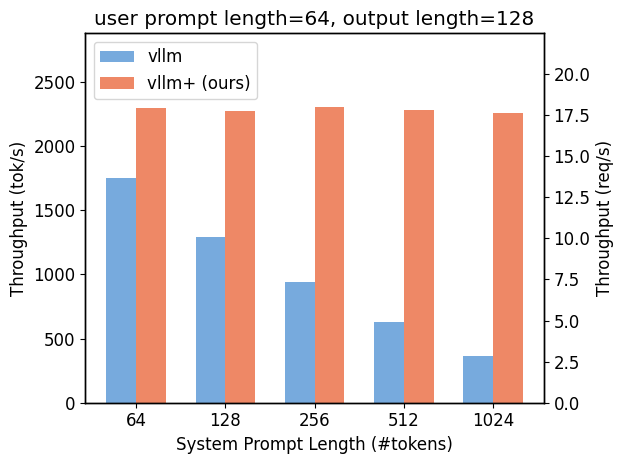

In [83]:
from matplotlib import pyplot as plt

nreqs_plot = 1000
ctxlen_plot, outlen_plot = (64, 128)

condition = (df['nreqs']==nreqs_plot) & (df['ctxlen'] == ctxlen_plot) & (df['outlen'] == outlen_plot) 
throughputs_relay = df[condition & (df['backend'] == 'vllm+')].sort_values('prefixlen')
throughputs_norelay = df[condition & (df['backend'] == 'vllm')].sort_values('prefixlen')

print(throughputs_norelay)

index=throughputs_relay['prefixlen'].to_numpy()
tok_per_sec={'vllm': throughputs_norelay['generate_tok_per_sec'].to_numpy(), 
             'vllm+ (ours)': throughputs_relay['generate_tok_per_sec'].to_numpy()}
req_per_sec={'vllm': throughputs_norelay['req_per_sec'].to_numpy(),
             'vllm+ (ours)': throughputs_relay['req_per_sec'].to_numpy()}

figsize=(8, 6)
plt.rcParams.update({'font.size': 12, 'font.serif': 'Times New Roman', 'axes.linewidth': 1})
save_path=os.path.join(benchmark_result_dir, f'throughput_bs{nreqs_plot}ctxlen{ctxlen_plot}outlen{outlen_plot}.svg')

import contextlib
# context = contextlib.nullcontext()
context = plt.style.context(['light'])

with context:
    figure, ax = plt.subplots()
    # plot barchart for throughputs (tok/s)
    _ = plot_multi_barchart(
        group_ids=index,
        data_dict=tok_per_sec,
        ax=ax, put_text_on_bars=False)
    max_y = max([max(x) for x in tok_per_sec.values()]) * 1.25
    ax.set_ylim((0, max_y))
    ax.set_ylabel('Throughput (tok/s)')
    ax.set_xlabel('System Prompt Length (#tokens)')
    ax.set_title(f'user prompt length={ctxlen_plot}, output length={outlen_plot}')
    ax.legend(loc='upper left')
    # plot linechart for throughput (req/s)
    ax2 = ax.twinx()
    # line_styles = ['-o', '-D']
    # for idx, (k, v) in enumerate(req_per_sec.items()):
    #     ax2.plot(v, line_styles[idx], label=k)
    ax2.set_ylabel('Throughput (req/s)')
    max_y = max([max(x) for x in req_per_sec.values()]) * 1.25
    ax2.set_ylim((0, max_y))
    # ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()